In [1]:
from model_utility import create_uncompiled_model
from data_pipeline import window_dataset
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
def get_dataset(global_batch_size, total_window_size, shift):
    
    df = pd.read_csv("D:/Università/Tesi/Dataset/data.csv")
    
    df.pop('Timestamp')
    
    wv = df['Wind_Speed']
    bad_wv = wv == -9999.0
    df["Wind_Speed"][bad_wv] = 0.0

    n = len(df)
    train_df = df[0: int(n*0.8)]
    val_df = df[int(n*0.8):]

    num_features = df.shape[1]

    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    
    train_df = window_dataset(train_df, total_window_size, shift, global_batch_size)
    val_df = window_dataset(val_df, total_window_size, shift, global_batch_size)
    
    return train_df, val_df, num_features

In [3]:
base_window = 144
shift = 16
batch_size = 32
total_window_size = base_window + shift

mse = tf.keras.metrics.MSE
mae = tf.keras.metrics.MAE

metrics = ["accuracy", mse, mae]

optimizer = tf.keras.optimizers.SGD(learning_rate = 10e-2, momentum=0.9)
train, val, num_features = get_dataset(batch_size, total_window_size, shift)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-3 * 10 ** (epoch / 20))

callbacks = [lr_schedule]

model = create_uncompiled_model(base_window, shift, num_features=3)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=metrics)

history = model.fit(train, epochs=100, validation_data=val, callbacks=callbacks)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Epoch 1/100
656/656 [==============================] - 100s 145ms/step - loss: 0.4082 - accuracy: 0.3820 - mean_squared_error: 0.9935 - mean_absolute_error: 0.7811 - val_loss: 0.4114 - val_accuracy: 0.4664 - val_mean_squared_error: 1.0045 - val_mean_absolute_error: 0.7861 - lr: 0.0010
Epoch 2/100
656/656 [==============================] - 92s 140ms/step - loss: 0.4014 - accuracy: 0.4459 - mean_squared_error: 0.9773 - mean_absolute_error: 0.7723 - val_loss: 0.4028 - val_accuracy: 0.4959 - val_mean_squared_error: 0.9832 - val_mean_absolute_error: 0.7750 - lr: 0.0011
Epoch 3/100
656/656 [==============================] - 85s 129ms/step - loss: 0.3893 - accuracy: 0.4824 - mean_squared_error: 0.9478 - mean_absolute_error: 0.7566 - val_loss: 0.3841 - val_accuracy: 0.5599 - val_mean_squared_erro

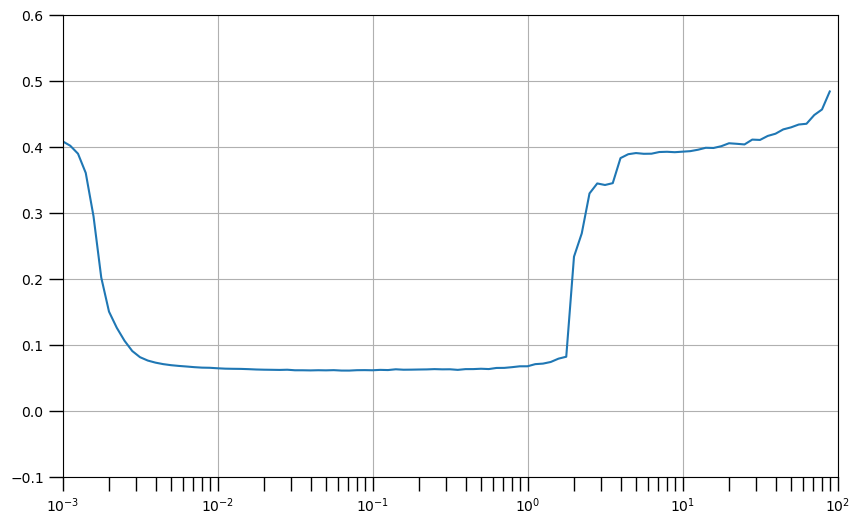

In [4]:
lrs = 1e-3 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history["loss"])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-3, 1e+2, -0.1, 0.6])
plt.show()
